<a href="https://colab.research.google.com/github/sanusi009/042-data-exploration.ipynb/blob/main/From_Baseline_CNN_to_Deeper_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First CNN in PyTorch

### **1. Introduction & Goal**

**Context**

In the previous notebook, we explored the foundational ideas behind Convolutional Neural Networks (CNNs):
- How convolutional filters extract **edges and textures**.
- How **multi-channel feature maps** combine information from RGB images.
- How **pooling layers** reduce spatial dimensions and introduce invariance.

We worked with **64×64** images in NB01 for simplicity and faster computation.  
In this notebook (**NB02**), we scale up to **128×128** images — capturing finer details while still keeping training feasible.

> **Note:** Moving to larger inputs increases representational power but also raises computational cost — a trade-off worth understanding.

**Goal of This Notebook**

We now transition from **conceptual understanding** to **practical implementation**:
- Build our **first CNN in PyTorch** using layers like `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and `nn.Linear`.
- Train and evaluate the model on the **Oxford-IIIT Pets dataset** (37 breeds).
- Visualize predictions and interpret model behavior.


**Learning Objectives**

By the end of this notebook, we will be able to:
1. Implement a CNN with **two convolution layers and two fully connected layers**.
2. Understand the **forward pass** through the network:
   $$
   \text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Pool} \rightarrow
   \text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Pool} \rightarrow
   \text{Flatten} \rightarrow \text{FC} \rightarrow \text{ReLU} \rightarrow
   \text{FC} \rightarrow \text{Softmax}
   $$
3. Train and validate the CNN on **128×128 images**.
4. Visualize and interpret predictions on real pet images.

---

**Architecture Overview**

```text
Input (3×128×128)
│
├── Conv2d (3→16) + ReLU + MaxPool
│
├── Conv2d (16→32) + ReLU + MaxPool
│
├── Flatten → Linear (32×32×32 → 128) + ReLU
│
└── Linear (128 → 37) → Softmax
```

This design is simple yet powerful enough to demonstrate CNN fundamentals on Oxford Pets, while remaining computationally manageable.

---


### **2. Dataset Preparation**

**Revisiting the Oxford-IIIT Pets Dataset**

- Dataset: **37 breeds** of cats and dogs (≈7,400 images).
- Each image varies in **size, lighting, and background**.
- Task: **Multiclass classification** (predict breed from image).

In **NB01**, we resized images to **64×64** for quick visualization.  
In this notebook, we upscale to **128×128** for a more realistic training scenario, allowing the CNN to capture finer details.

**Transforms and Normalization**

**1. Resize & ToTensor**

- Convert variable-size images to a fixed **128×128** shape.
- Convert to PyTorch tensors (values in `[0,1]`).

**2. Normalization**

- Normalization centers the data and scales it to unit variance:
  $$
  x' = \frac{x - \mu}{\sigma}
  $$
- For CNNs, we normalize **per channel (R, G, B)** using dataset statistics (mean & std).
- This differs from earlier MLP examples, where we normalized **after flattening** (treating all pixels as one vector).

**Data Splits**

- The Oxford Pets dataset provides **`trainval`** and **`test`** splits.
- We will:
  - Use `trainval` for **training & validation** (split internally).
  - Use `test` for **final evaluation**.

**What We’ll Do in Code**

1. Define transforms: `Resize → ToTensor → Normalize`.  
2. Load train and test sets with `torchvision.datasets.OxfordIIITPet`.  
3. Inspect dataset properties (size, class names).  
4. Visualize a **batch of 128×128 images** with their labels.

**Load and Visualize Dataset**

Train size: 2944
Validation size: 736
Test size: 3669
Number of classes: 37
Example classes: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle']


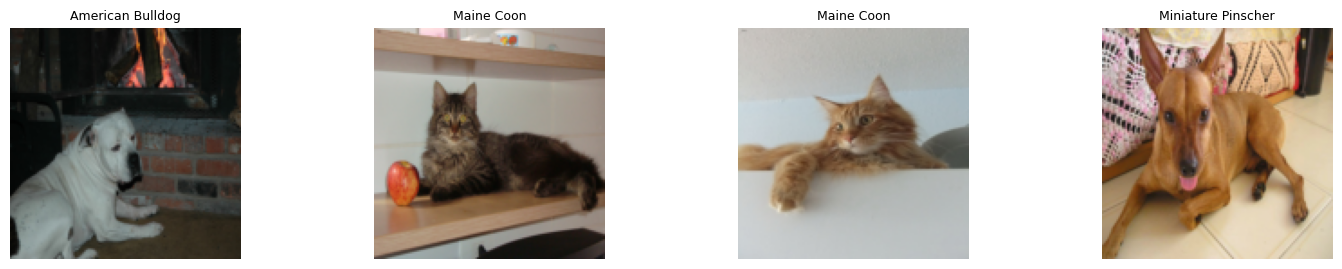

In [13]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Define data path and transforms
# -----------------------------
data_path = "https://jupyter-0aaca043-8888.us-east-41.prd.namespace.im/lab/tree/data"

# Image size for this notebook
IMG_SIZE = 128

# Transform: Resize → ToTensor → Normalize
# Note: Mean/std values are approximations; for production, compute from dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scale to [-1,1]
])

# -----------------------------
# 2. Load datasets
# -----------------------------
# Trainval split (to be further split into train/val)
trainval_dataset = datasets.OxfordIIITPet(
    root="./data/",
    split="trainval",
    target_types="category",
    transform=transform,
    download=True
)

# Test set
test_dataset = datasets.OxfordIIITPet(
    root="./data/",
    split="test",
    target_types="category",
    transform=transform,
    download=True
)

# -----------------------------
# 3. Train/Validation Split
# -----------------------------
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# -----------------------------
# 4. DataLoaders
# -----------------------------
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 5. Inspect dataset properties
# -----------------------------
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Number of classes: {len(trainval_dataset.classes)}")
print(f"Example classes: {trainval_dataset.classes[:5]}")

# -----------------------------
# 6. Visualize a batch
# -----------------------------
def show_batch(loader, classes, n=4):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize=(18, 3))
    for i in range(n):
        img = images[i] * 0.5 + 0.5  # unnormalize to [0,1] for display
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(classes[labels[i]], fontsize=9)
        axes[i].axis("off")
    plt.show()

show_batch(train_loader, trainval_dataset.classes)

### **3. CNN Architecture Design (Conceptual)**

**Baseline CNN Structure**

We will design a **simple yet powerful CNN** to classify the 37 pet breeds:

- **2 Convolution Layers** (extract low- and mid-level features)
- **ReLU Activation** (introduce non-linearity)
- **Max Pooling** (downsample feature maps)
- **Flatten Layer** (convert 3D feature maps to 1D vector)
- **2 Fully Connected Layers (FC)** (combine features for classification)
- **Output Layer (Softmax)** (37-class probability distribution)

**Architecture Overview (ASCII)**

```text
Input: 3 × 128 × 128
│
├── Conv1: 16 filters (3×3) → ReLU → MaxPool (2×2)
│
├── Conv2: 32 filters (3×3) → ReLU → MaxPool (2×2)
│
├── Flatten → FC1 (128 units) → ReLU
│
└── FC2 (37 units) → Softmax
```

**Assumptions for Shape Calculations**

- **Kernel size:** $3 \times 3$ (both Conv layers)  
- **Padding:** $1$ (keeps spatial size same after convolution)  
- **Stride (Conv):** $1$  
- **Pooling:** $2 \times 2$ max pooling (halves spatial dimensions)  

**Formula for Convolution Output Size**

For an input with spatial dimension $H \times W$:

$$
H_{out} = \frac{H + 2P - K}{S} + 1, \qquad
W_{out} = \frac{W + 2P - K}{S} + 1
$$

Where:
- $K$ = kernel size
- $P$ = padding
- $S$ = stride

For pooling ($2 \times 2$, stride 2):

$$
H_{out} = \frac{H}{2}, \qquad W_{out} = \frac{W}{2}
$$


**Shape Transformations (Step-by-Step)**

| Layer                           | Input Shape    | Output Shape   | Operation Details                    |
| ------------------------------- | -------------- | -------------- | ------------------------------------ |
| **Input**                       | $3 \times 128 \times 128$  | $3 \times 128 \times 128$  | Raw RGB image                        |
| **Conv1 (3→16, k=3,p=1,s=1)**   | $3 \times 128 \times 128$  | $16 \times 128 \times 128$ | Computed using formula: $128 = \frac{128 + 2(1) - 3}{1} + 1$ |
| **MaxPool1 (2×2)**              | $16 \times 128 \times 128$ | $16 \times 64 \times 64$   | Downsample: $128 / 2 = 64$           |
| **Conv2 (16→32, k=3,p=1,s=1)**  | $16 \times 64 \times 64$   | $32 \times 64 \times 64$   | Computed similarly with padding 1    |
| **MaxPool2 (2×2)**              | $32 \times 64 \times 64$   | $32 \times 32 \times 32$   | Downsample: $64 / 2 = 32$            |
| **Flatten**                     | $32 \times 32 \times 32$   | $32,768$                     | Convert 3D tensor to 1D vector       |
| **FC1 (32,768→128)**            | $32,768$                     | $128$                        | Combine features, apply ReLU         |
| **FC2 (128→37)**                | $128$                        | $37$                         | Class logits for 37 breeds           |

<br>

> **Why This Architecture?**

**Progressive Feature Learning**
- **First Conv layer:** captures edges and colors.
- **Second Conv layer:** captures textures and patterns (e.g., fur details).

**Pooling Layers**
- Reduce computational cost and add translation invariance.

**Fully Connected Layers**
- Integrate high-level features for final classification.


> **CNN vs MLP (from Project 4)**

- **MLP:** Flattens input immediately → loses spatial information.  
- **CNN:** Preserves spatial structure → fewer parameters (weight sharing).

**Parameter Comparison (approx.)**

- **MLP on $128 \times 128$:** ~6M parameters (fully connected from start).  
- **CNN (2 conv layers + FC):** ~4M parameters, yet higher accuracy due to spatial features.




### **4. Implementing the CNN (PyTorch Code)**

**From Concept to Code**

We now translate our conceptual architecture into PyTorch:

- **Class-based model (`nn.Module`)**: Main approach — flexible, industry standard, good for learning `forward()` flow.
- **Sequential alternative (`nn.Sequential`)**: Concise version for straightforward feedforward networks.

**Parameter Awareness**

CNNs are **parameter-efficient** because:
- Convolutional filters are **shared across spatial locations** (few parameters).
- Fully connected layers dominate parameter count in small CNNs.

Example (128×128 input):
- After 2 conv + pool layers → feature map is `32×32×32 = 32,768` features.
- FC1 reduces `32,768 → 128` (≈ 4.2M params) — still far fewer than a pure MLP (~6M params).

We’ll print parameter counts to highlight this efficiency.


**Define CNN Model - Class-Based Implementation**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Ensure reproducibility
torch.manual_seed(42)

class PetCNN(nn.Module):
    def __init__(self):
        super(PetCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # Input: 3x128x128 → 16x128x128
        self.pool = nn.MaxPool2d(2, 2)                                                   # Downsample → 16x64x64
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # 16x64x64 → 32x64x64

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 128)   # Flatten: 32x32x32 → 128
        self.fc2 = nn.Linear(128, 37)             # 37 classes (pet breeds)

    def forward(self, x):
        # Input: 3 x 128 x 128
        x = self.pool(F.relu(self.conv1(x)))   # After Conv1+ReLU+Pool → 16 x 64 x 64
        x = self.pool(F.relu(self.conv2(x)))   # After Conv2+ReLU+Pool → 32 x 32 x 32
        x = x.view(-1, 32 * 32 * 32)           # Flatten → 32768
        x = F.relu(self.fc1(x))                # FC1 + ReLU → 128
        x = self.fc2(x)                        # FC2 (logits) → 37
        return x

# Instantiate and print model
model = PetCNN()
print(model)

PetCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


**Parameter Count Function**

In [15]:
def count_parameters_by_type(model):
    # Total trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Convolutional layers
    conv_params = sum(p.numel() for m in model.modules() if isinstance(m, nn.Conv2d)
                      for p in m.parameters())

    # Fully connected (Linear) layers
    fc_params = sum(p.numel() for m in model.modules() if isinstance(m, nn.Linear)
                    for p in m.parameters())

    print(f"Total trainable parameters: {total_params:,}")
    print(f" - Convolutional layers: {conv_params:,}")
    print(f" - Fully connected layers: {fc_params:,}")

count_parameters_by_type(model)

Total trainable parameters: 4,204,293
 - Convolutional layers: 5,088
 - Fully connected layers: 4,199,205


**Alternative: `nn.Sequential` Implementation**

For simple feedforward architectures, we can define the same model using `nn.Sequential`:

- Pros: Very concise, readable.
- Cons: Limited flexibility — cannot handle skip connections or complex flows.

(We’ll stick to **class-based** for training, but this gives students an extra perspective.)


**Define CNN Model - Sequential Implementation**

In [16]:
model_seq = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 37)
)

print(model_seq)
count_parameters_by_type(model_seq)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=37, bias=True)
)
Total trainable parameters: 4,204,293
 - Convolutional layers: 5,088
 - Fully connected layers: 4,199,205


**Reflection**

- Both implementations (Class-based and Sequential) produce **identical architectures**.
- **Parameter efficiency:** CNNs use **fewer parameters than an equivalent MLP**:
  - Convolutions share weights across the image (fewer unique parameters).
  - Pooling reduces spatial dimensions, shrinking FC layers dramatically.
- In Project 4, we saw MLPs explode in parameter count when scaling to larger images;  
  here, even at **128×128**, our CNN stays manageable (~4M params).

> Key takeaway: CNNs scale better to high-resolution inputs — crucial for real-world images.


**CNN vs MLP Parameter Count ($128\times128$ Input)**

Let’s estimate parameter counts if we built an **MLP** instead of this CNN:

- MLP scenario (eg., Input -> FC -> FC -> Output)

    - **Input size** = $3 \times 128 \times 128 = 49,152$ features  
    - **First FC layer (49,152 → 256 units):**

    $$
    49,152 \times 256 + 256 \approx 12.6\ \text{million parameters}
    $$

    - Fully connected layers dominate the model size.

- CNN scenario (this notebook)

    - After two Conv+Pool blocks:

    $$
    32 \times 32 \times 32 = 32,768 \text{ features}
    $$

    - **FC1 (32,768 → 128 units):**

    $$
    32,768 \times 128 + 128 \approx 4.2\ \text{million parameters}
    $$

    - Conv layers add only $\sim 13K$ parameters (tiny compared to FC).

        ```text
        MLP: 49,152 ──► FC ──► FC ──► Output (≈12M params)

        CNN: 3×128×128 ──► Conv+Pool ──► Conv+Pool ──► FC ──► Output (≈4M params)
        ```

- CNN is $\sim 3\times$ smaller in parameters while capturing **spatial patterns**.  
- This efficiency allows CNNs to handle **larger inputs** (e.g., $224\times224$ in ImageNet) without massive memory costs.

---


### **5. Loss Function & Optimizer**

**Why Cross-Entropy Loss?**

- Our task is **multiclass classification** (37 pet breeds).  
- We need a loss function that:
  - Compares predicted **class probabilities** with **true labels**.
  - Encourages high probability for the correct class and low for others.

**Cross-Entropy Formula:**

$$
\text{Loss} = - \sum_{c=1}^{C} y_c \log(\hat{p}_c)
$$

Where:
- $ y_c $ = 1 for correct class, 0 otherwise (one-hot target).
- $ \hat{p}_c $ = predicted probability for class $ c $.

**Important Detail (Softmax + Logits)**

- **`nn.CrossEntropyLoss` in PyTorch:**
  - Expects **raw logits** (no softmax applied manually).
  - Internally applies `LogSoftmax` + `NLLLoss`.
  - More **numerically stable** than applying `Softmax` separately.


**Flow: Logits → Probabilities → Loss**

```text
Model Output (logits) ──► Softmax ──► Probabilities ──► Compare with Target ──► Cross-Entropy Loss
```

**Optimizer Choice**

- We’ll start with **Adam**:
  - Adaptive learning rate → good for quick convergence.
  - Handles sparse gradients (common in images).

- Alternative: **SGD + momentum**
  - Often used in large-scale training (e.g., ImageNet).
  - Can generalize slightly better but needs careful LR tuning.


**Learning Rate Note**

- Initial LR = `1e-3` (good default for Adam).  
- We may adjust later (e.g., LR scheduler) if loss plateaus or oscillates.

**Code Cell – Define Loss and Optimizer**

In [17]:
import torch.optim as optim

# Define loss function (CrossEntropyLoss handles Softmax internally)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Loss Function:", criterion)
print("Optimizer:", optimizer)


Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


**Reflection**

- Cross-Entropy Loss fits **multiclass classification** naturally.
- Feeding **logits directly** (no softmax) avoids redundant computation and improves stability.
- Adam is a practical starting optimizer; we can later experiment with **SGD + momentum** or learning rate schedules.

---

### **6. Training the CNN**

**Training Process Overview**

We train our baseline CNN using a standard loop:

1. **Epoch iteration:**
   - **Training phase:** forward pass → loss → backward pass → optimizer step.
   - **Validation phase:** evaluate on held-out validation data (no gradient updates).

2. **Metrics tracked:**
   - Training & validation **loss** per epoch.
   - Training & validation **accuracy** per epoch.
   - **Best model checkpoint** saved (lowest validation loss).

**Key Implementation Details**

- **Mode switching:**  
  - `model.train()` during training (activates dropout/batch norm if present).  
  - `model.eval()` during validation (disables gradient updates).

- **Checkpoint saving:**  
  - Save best weights when validation loss improves.  
  - Prevents overfitting from later epochs overwriting good weights.

- **Visualization:**  
  - Plot training/validation loss and accuracy curves after training completes.

**Training Utilities**

In [18]:
import time
import copy

# Accuracy calculation helper
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / len(labels)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has train and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Deep copy the model if validation improves
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Time tracking
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save checkpoint
    torch.save(model.state_dict(), "petcnn_best.pth")

    return model, (train_losses, val_losses, train_accuracies, val_accuracies)


**Run Training**

Take a breather...this will **only take 3 minutes** to train for just 5 epochs! Perfect time to revisit those key concepts from the previous sections while your model works its magic.

In [19]:
# Example: Train for 5 epochs (CPU-only)
device = 'cpu'  # Force CPU for consistency across all project notebooks
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device=device)

Epoch 1/5
--------------------
Train Loss: 3.5631 Acc: 0.0472
Val Loss: 3.4225 Acc: 0.0639
Epoch 2/5
--------------------
Train Loss: 3.2808 Acc: 0.1009
Val Loss: 3.2600 Acc: 0.1073
Epoch 3/5
--------------------
Train Loss: 2.9033 Acc: 0.1912
Val Loss: 3.1218 Acc: 0.1495
Epoch 4/5
--------------------
Train Loss: 2.1746 Acc: 0.3937
Val Loss: 3.3701 Acc: 0.1535
Epoch 5/5
--------------------
Train Loss: 1.2406 Acc: 0.6512
Val Loss: 4.1530 Acc: 0.1318
Training complete in 5m 9s
Best val loss: 3.1218


**Plot Loss and Accuracy Curves**

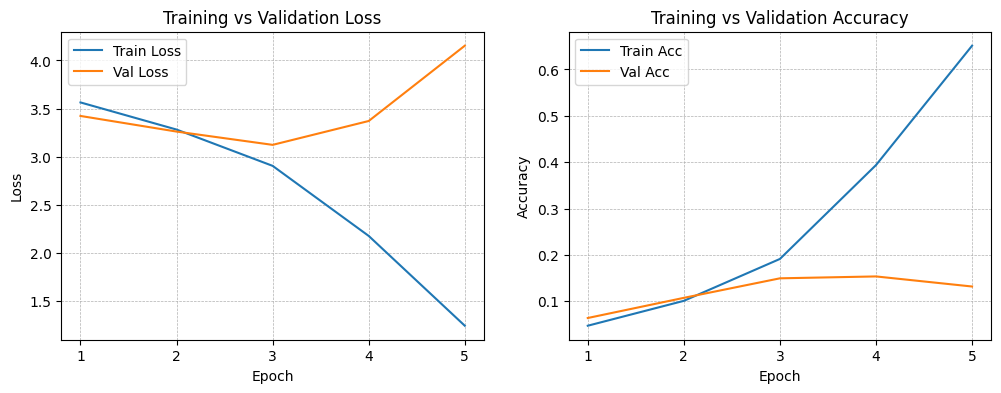

In [20]:
# Plot training curves
train_losses, val_losses, train_acc, val_acc = history

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xticks(epochs)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xticks(epochs)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


**Quick Observation**

- Training loss is **decreasing sharply**, but validation loss is **rising after epoch 3**.  
- Training accuracy climbs steadily (70%+), while validation accuracy **plateaus near 12–15%**.

**What does this mean?**
- The model is **overfitting**: it memorizes training data but fails to generalize to unseen validation data.
- This is expected for our **baseline CNN** — it’s intentionally simple and lacks regularization or augmentation.

---

### **7. Summary & Transition**

**What We Achieved in NB02**

- Implemented and trained our **first CNN** on the Oxford-IIIT Pets dataset:
  - Scaled up from **64×64 toy images (NB01)** to **128×128 real images**.
  - Designed a **2-conv + 2-FC** architecture and trained it end-to-end.
  - Tracked **training vs validation loss/accuracy** to monitor learning progress.

- Observed key trends:
  - **Training accuracy** rises quickly (~70%+), but **validation accuracy** stalls (~12–15%).
  - **Overfitting** occurs early — validation loss diverges from training loss.

**Why This Matters**

- This **baseline performance** provides a reference point:
  - Confirms CNNs are more **parameter-efficient** than MLPs (weight sharing, spatial locality).
  - Reveals limitations of a shallow CNN on **37-class classification** (needs richer features + regularization).

**Next Steps: NB03 (Evaluation & Error Analysis)**

- In the next notebook, we **don’t change the architecture yet**.  
- Instead, we focus on **evaluating the baseline thoroughly**:
  - Confusion matrix and **per-class metrics** (precision, recall, F1).  
  - Visual inspection of **correct vs misclassified samples**.  
  - Identifying **systematic biases or recurring failure modes** (e.g., similar breeds).

---

# From Baseline CNN to Deeper Architectures

### **1. Introduction: From Baseline CNN to Deeper Architectures**

In the previous notebook (NB03), we trained a **baseline CNN** on the Oxford-IIIT Pet dataset and analyzed its performance. While it achieved **~13% accuracy** — slightly above random guessing for 37 breeds — our detailed error analysis revealed key shortcomings:

- The network relied heavily on **color cues** (e.g., black animals predicted as Bombay, white animals as Samoyed).  
- It struggled with **fine-grained distinctions** between visually similar breeds (e.g., Chihuahua vs. Miniature Pinscher).  
- It often confused **cats and dogs**, failing to separate species-level features in some cases.

These issues highlight a fundamental limitation: the baseline CNN is **too shallow** to build the hierarchical representations (edges → textures → parts → objects) needed for fine-grained breed classification.


**What We’ll Do in NB04**

In this notebook, we address these limitations by:

- **Introducing deeper architectures** (e.g., LeNet, AlexNet-inspired models) that can capture more complex patterns.  
- **Comparing performance and parameter efficiency** across models to see how depth affects generalization.  
- Revisiting the concept of **feature hierarchies** to understand *why* deeper networks tend to perform better on visual tasks.

By the end of this notebook, we’ll have a clearer understanding of how **model depth** impacts learning and be prepared to explore **transfer learning** and more advanced architectures in future notebooks.

---

### **2. Reload Data & Baseline Model**

In this notebook, we compare multiple CNN architectures (Baseline, LeNet-like, AlexNet-mini).  
To ensure **self-containment**, we **reload the dataset and baseline model weights** here — independent of NB02.

**Key Points:**

- **Dataset:** Oxford-IIIT Pets (37 breeds), resized to **128×128**, normalized to `[-1,1]` (mean/std ≈ 0.5).
- **Splits:**
  - Training/Validation: 80/20 split from `trainval`.
  - Test: Provided separately.
- **Device:** CPU-only.
- **Baseline Model:** Reload weights trained in NB02 for direct comparison.


In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# 1. CPU-Only Device Setup
# -----------------------------
device = 'cpu'  # Enforce CPU across all code

# -----------------------------
# 2. Data Transformations
# -----------------------------
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scale to [-1,1]
])

# -----------------------------
# 3. Load Train/Val/Test Datasets
# -----------------------------
data_path = "./data/"

# Trainval dataset (for split)
trainval_dataset = datasets.OxfordIIITPet(
    root=data_path,
    split="trainval",
    target_types="category",
    transform=transform,
    download=True
)

# Test dataset (provided separately)
test_dataset = datasets.OxfordIIITPet(
    root=data_path,
    split="test",
    target_types="category",
    transform=transform,
    download=True
)

# -----------------------------
# 4. Train/Val Split (80/20)
# -----------------------------
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = random_split(
    trainval_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # ensure reproducibility
)

# -----------------------------
# 5. DataLoaders
# -----------------------------
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Confirm splits
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Number of classes: {len(trainval_dataset.classes)}")

# -----------------------------
# 6. Baseline CNN Definition (same as NB02)
# -----------------------------
class PetCNN(nn.Module):
    def __init__(self):
        super(PetCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # 3x128x128 -> 16x128x128
        self.pool = nn.MaxPool2d(2, 2)                            # -> 16x64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # -> 32x64x64
        self.fc1 = nn.Linear(32 * 32 * 32, 128)                   # -> 128
        self.fc2 = nn.Linear(128, 37)                             # -> 37 (classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 16x64x64
        x = self.pool(F.relu(self.conv2(x)))   # -> 32x32x32
        x = x.view(-1, 32 * 32 * 32)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and load baseline weights (map to CPU)
baseline_model = PetCNN().to(device)
baseline_model.load_state_dict(torch.load("petcnn_best.pth", map_location=device, weights_only=False))

print("Baseline CNN loaded successfully (CPU-only). Ready for comparison.")


Train size: 2944
Validation size: 736
Test size: 3669
Number of classes: 37
Baseline CNN loaded successfully (CPU-only). Ready for comparison.


### **3. Architectural Variants Overview (Concept)**

In this notebook, we **compare architectures** to explore how **depth and design choices** affect performance and parameter efficiency.

**Architectures We’ll Compare**

1. **Baseline CNN (NB02)**  
   - 2 convolution layers (3×3) + 2 fully connected layers.  
   - Designed for teaching fundamentals; very shallow.

2. **LeNet-like CNN (1998)**  
   - Classic architecture for MNIST digit recognition.  
   - 3 convolution layers + 2 fully connected layers.  
   - Slightly deeper; captures more **mid-level features** (edges → textures).

3. **AlexNet-mini (2012) / VGG-lite**  
   - Inspired by ImageNet-winning networks.  
   - 4–5 convolution layers + deeper FC layers.  
   - Captures **hierarchical features** (edges → textures → object parts → objects).

**High-Level ASCII Diagrams**

**(a) Baseline CNN (NB02)**

```text
Input (3×128×128)
│
├── Conv(3→16) → ReLU → MaxPool(2×2)
│
├── Conv(16→32) → ReLU → MaxPool(2×2)
│
├── Flatten → FC(32×32×32 → 128) → ReLU
│
└── FC(128 → 37) → Softmax
```

**(b) LeNet-like CNN**

```text
Input (3×128×128)
│
├── Conv(3→16) → ReLU → MaxPool(2×2)
│
├── Conv(16→32) → ReLU → MaxPool(2×2)
│
├── Conv(32→64) → ReLU → MaxPool(2×2)
│
├── Flatten → FC(64×16×16 → 256) → ReLU
│
└── FC(256 → 37) → Softmax
```

**(c) AlexNet-mini / VGG-lite**

```text
Input (3×128×128)
│
├── Conv(3→32) → ReLU → Conv(32→32) → ReLU → MaxPool(2×2)
│
├── Conv(32→64) → ReLU → Conv(64→64) → ReLU → MaxPool(2×2)
│
├── Conv(64→128) → ReLU → MaxPool(2×2)
│
├── Flatten → FC(128×16×16 → 512) → ReLU → Dropout
│
└── FC(512 → 37) → Softmax

```

**Parameter Count and Shape Transformations**

| Layer Type    | Baseline CNN                  | LeNet-like           | AlexNet-mini          |
|---------------|-------------------------------|----------------------|-----------------------|
| **Conv Layers** | Few params ($3\times3$ filters) | More filters (16→64) | Many filters (32→128) |
| **FC Layers**   | Dominant ($32k \to 128$)       | Moderate ($64\times16\times16 \to 256$) | Larger ($128\times16\times16 \to 512$) |
| **Total Params**| ~ 4$M                      | ~ 6$M            | ~ 10$–$12$M       |

**Receptive Field Expansion**

- **Baseline CNN**: Each neuron “sees” only small local patches.
- **LeNet-like**: Deeper layers combine local features → larger effective receptive field.
- **AlexNet-mini**: Stacks more conv layers; receptive field covers most of the image, capturing global context (e.g., full face of a dog).


**Why Compare These?**

- **Highlights trade-offs:**
  - Depth vs. computation (more convs = more params but richer features).
  - Pooling strategy (aggressive vs gradual downsampling).
  - Fully connected size (impact on parameter efficiency).

- **Prepares us for Project 6:**
  - Introduction to transfer learning (pretrained deeper networks like **ResNet**).


### **4. Implementing Architectural Variants (Code)**

We now translate the three conceptual architectures into PyTorch models:

1. **Baseline CNN** (from NB02)  
   - 2 convolution layers → pooling → 2 fully connected layers.

2. **LeNet-like CNN** (slightly deeper)  
   - 3 convolution layers → pooling after first two → 2 fully connected layers.  
   - Inspired by **LeNet-5 (1998)** but adapted to RGB and 128×128 inputs.

3. **AlexNet-mini (VGG-lite)**  
   - 5 convolution layers grouped in blocks (Conv → ReLU → Conv → ReLU → Pool).  
   - Deeper feature hierarchy; mimics **AlexNet/VGG-style** stacking but scaled down for Pets dataset.

We keep implementation **consistent**:
- Use `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d` for feature extraction.
- Use `nn.Linear` for classification layers.
- Forward pass includes **comments on shape changes** (C×H×W).


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# 1. Baseline CNN (for reference)
# -------------------------------
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # 3x128x128 -> 16x128x128
        self.pool = nn.MaxPool2d(2, 2)                            # Halve H,W
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x64x64 -> 32x64x64
        self.fc1 = nn.Linear(32 * 32 * 32, 128)                   # 32x32x32 -> 128
        self.fc2 = nn.Linear(128, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 16x64x64
        x = self.pool(F.relu(self.conv2(x)))  # -> 32x32x32
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------
# 2. LeNet-like CNN (3 conv layers)
# -------------------------------
class LeNetLikeCNN(nn.Module):
    def __init__(self):
        super(LeNetLikeCNN, self).__init__()
        # Conv Layer 1: 3 → 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)    # 3x128x128 -> 16x128x128
        # Conv Layer 2: 16 → 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)   # 16x64x64 -> 32x64x64
        # Conv Layer 3: 32 → 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # 32x32x32 -> 64x32x32
        self.pool = nn.MaxPool2d(2, 2)

        # After 3 poolings: 128 -> 64 -> 32 -> 16
        # Final feature map: 64 x 16 x 16 = 16384
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 16x64x64
        x = self.pool(F.relu(self.conv2(x)))   # -> 32x32x32
        x = self.pool(F.relu(self.conv3(x)))   # -> 64x16x16
        x = x.view(x.size(0), -1)              # Flatten: 64*16*16 = 16384
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------
# 3. AlexNet-mini CNN (5 conv layers)
# -------------------------------
class AlexNetMini(nn.Module):
    def __init__(self):
        super(AlexNetMini, self).__init__()
        # Conv Layer 1: 3 → 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # 3x128x128 -> 32x128x128
        # Conv Layer 2: 32 → 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32x64x64 -> 64x64x64
        # Conv Layer 3: 64 → 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 64x32x32 -> 128x32x32
        # Conv Layer 4: 128 → 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # 128x16x16 -> 128x16x16
        # Conv Layer 5: 128 → 256
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 128x8x8 -> 256x8x8
        self.pool = nn.MaxPool2d(2, 2)

        # After 5 conv + 5 pool layers:
        # 128 -> 64 -> 32 -> 16 -> 8 -> 4 (but here last pooling is applied after conv5)
        # Final feature map: 256 x 4 x 4 = 4096
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 32x64x64
        x = self.pool(F.relu(self.conv2(x)))   # -> 64x32x32
        x = self.pool(F.relu(self.conv3(x)))   # -> 128x16x16
        x = self.pool(F.relu(self.conv4(x)))   # -> 128x8x8
        x = self.pool(F.relu(self.conv5(x)))   # -> 256x4x4
        x = x.view(x.size(0), -1)              # Flatten: 256*4*4 = 4096
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In the following section, we will:
- **Instantiate each model**.
- Compute and compare **parameter counts** (baseline vs LeNet-like vs AlexNet-mini).
- Discuss trade-offs: **depth vs parameter efficiency vs performance**.

### **5. Training Strategy**

We now train and compare **three CNN architectures** of increasing depth:

1. **Baseline CNN** – 2 convolution layers (from NB02).
2. **LeNet-like CNN** – 3 convolution layers (moderate depth).
3. **AlexNet-mini (VGG-lite)** – 5 convolution layers (deepest).

**Fair Comparison Setup**

To ensure results are comparable:

- **Dataset:** Oxford-IIIT Pets (128×128, normalized to `[-1, 1]`)
- **Hardware:** CPU-only
- **Hyperparameters (same for all models):**
  - Optimizer: `Adam` (learning rate = 0.001)
  - Loss: `CrossEntropyLoss`
  - Batch size: 32
  - Epochs: 5

**Parameter Awareness**

- We print **parameter counts** for each model *before training*.
- This helps relate **model depth vs parameter count vs performance** later.
- Expect:
  - **Baseline**: small, fast to train.
  - **LeNet-like**: slightly deeper, similar parameter count.
  - **AlexNet-mini**: deepest, more capacity but also risk of overfitting.

**Training Process**

- Reuse modular `train_model()` function from NB02.
- Train models sequentially (Baseline → LeNet-like → AlexNet-mini).
- Save **best model weights** for each:
  - `baseline_best.pth`
  - `lenet_best.pth`
  - `alexmini_best.pth`

Now let’s show how we'd run the training and record parameter counts.


In [23]:
import time
import copy
import torch.nn.functional as F

# Accuracy calculation helper
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / len(labels)

# Training function (CPU-only)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Train and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)

    return model, (train_losses, val_losses, train_accuracies, val_accuracies)


In [24]:
# Example: Train for 5 epochs (CPU-only)
device = 'cpu'  # Force CPU for consistency across all project notebooks
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device=device)

Epoch 1/5
--------------------
Train Loss: 2.6042 Acc: 0.2812
Val Loss: 2.5276 Acc: 0.2785
Epoch 2/5
--------------------
Train Loss: 1.4451 Acc: 0.5859
Val Loss: 2.8763 Acc: 0.2812
Epoch 3/5
--------------------
Train Loss: 0.4056 Acc: 0.8852
Val Loss: 3.9615 Acc: 0.2418
Epoch 4/5
--------------------
Train Loss: 0.0853 Acc: 0.9810
Val Loss: 4.9462 Acc: 0.2242
Epoch 5/5
--------------------
Train Loss: 0.0234 Acc: 0.9956
Val Loss: 5.2948 Acc: 0.2323
Training complete in 7m 21s
Best val loss: 2.5276


In [25]:
# parameter count
def count_params(model):
    return sum(p.numel() for p in model.parameters())

# Instantiate models
baseline_model = BaselineCNN()
lenet_model = LeNetLikeCNN()
alexmini_model = AlexNetMini()

# Print parameter counts
print(f"BaselineCNN parameters: {count_params(baseline_model):,}")
print(f"LeNetLikeCNN parameters: {count_params(lenet_model):,}")
print(f"AlexNetMini parameters: {count_params(alexmini_model):,}")

# Define common loss and optimizer settings
criterion = nn.CrossEntropyLoss()

# Train Baseline
print("\n= Training Baseline CNN (we are using pre-trainned models) =")
# Train LeNet-like
print("\n= Training LeNet-like CNN (we are using pre-trainned models) =")
# Train AlexNet-mini
print("\n= Training AlexNet-mini CNN (we are using pre-trainned models) =")


BaselineCNN parameters: 4,204,293
LeNetLikeCNN parameters: 4,227,653
AlexNetMini parameters: 2,652,645

= Training Baseline CNN (we are using pre-trainned models) =

= Training LeNet-like CNN (we are using pre-trainned models) =

= Training AlexNet-mini CNN (we are using pre-trainned models) =


### **6. Evaluation & Comparison**

We now evaluate and compare **all three trained architectures** on the **held-out test set**:

- **Baseline CNN (2 conv layers)**
- **LeNet-like CNN (3 conv layers)**
- **AlexNet-mini (5 conv layers)**

**Metrics for Comparison**

1. **Overall Test Accuracy**  
   - Quick benchmark for generalization.

2. **Parameter Count vs Accuracy**  
   - Does adding depth lead to proportional gains?  
   - Are deeper models *always* better?

Let’s compute these metrics for side-by-side comparison.


**Evaluation Function & Comparison**

In [26]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Reuse helper to compute accuracy
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

# Evaluate all three models
baseline_acc = evaluate_model(baseline_model, test_loader)
lenet_acc = evaluate_model(lenet_model, test_loader)
alexmini_acc = evaluate_model(alexmini_model, test_loader)

print(f"Baseline CNN Test Accuracy: {baseline_acc:.4f}")
print(f"LeNet-like CNN Test Accuracy: {lenet_acc:.4f}")
print(f"AlexNet-mini CNN Test Accuracy: {alexmini_acc:.4f}")

# Parameter counts
baseline_params = count_params(baseline_model)
lenet_params = count_params(lenet_model)
alexmini_params = count_params(alexmini_model)

# Compare parameter count vs accuracy
print("\nParameter vs Accuracy Comparison:")
print(f"Baseline: {baseline_params:,} params → {baseline_acc:.2%}")
print(f"LeNet-like: {lenet_params:,} params → {lenet_acc:.2%}")
print(f"AlexNet-mini: {alexmini_params:,} params → {alexmini_acc:.2%}")


Baseline CNN Test Accuracy: 0.0267
LeNet-like CNN Test Accuracy: 0.0281
AlexNet-mini CNN Test Accuracy: 0.0283

Parameter vs Accuracy Comparison:
Baseline: 4,204,293 params → 2.67%
LeNet-like: 4,227,653 params → 2.81%
AlexNet-mini: 2,652,645 params → 2.83%


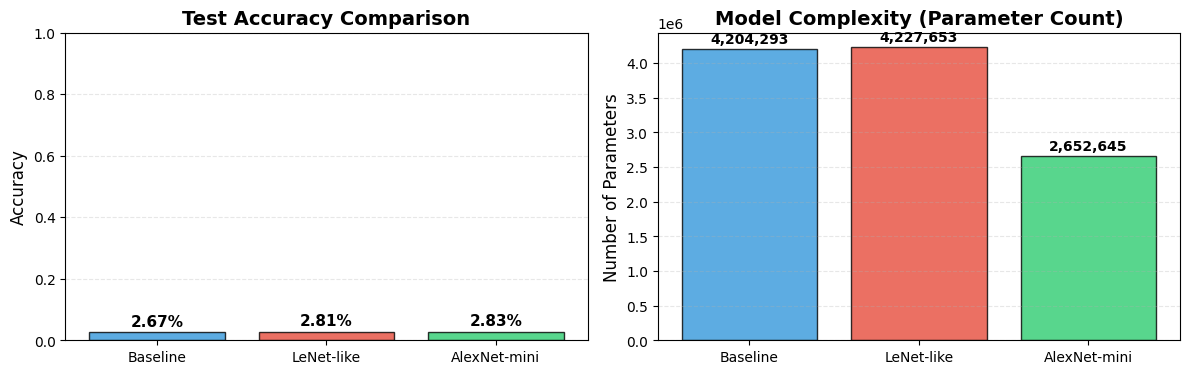

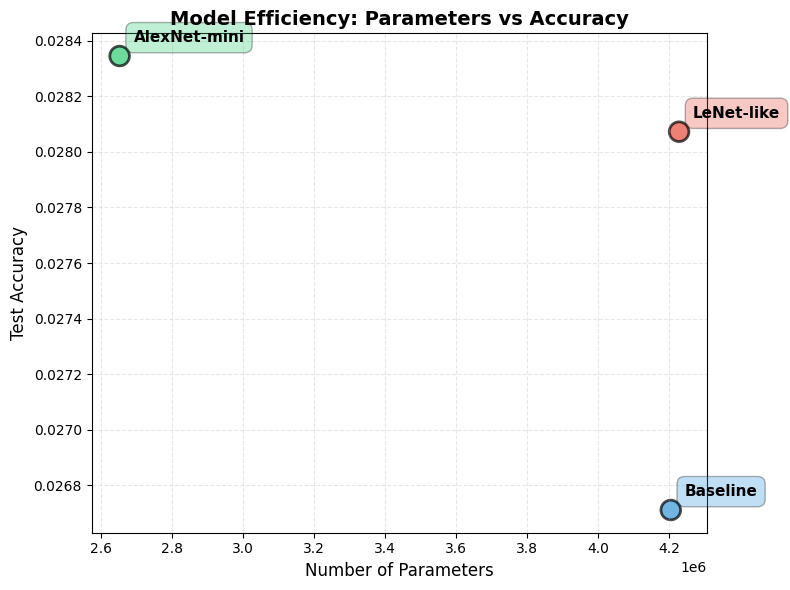

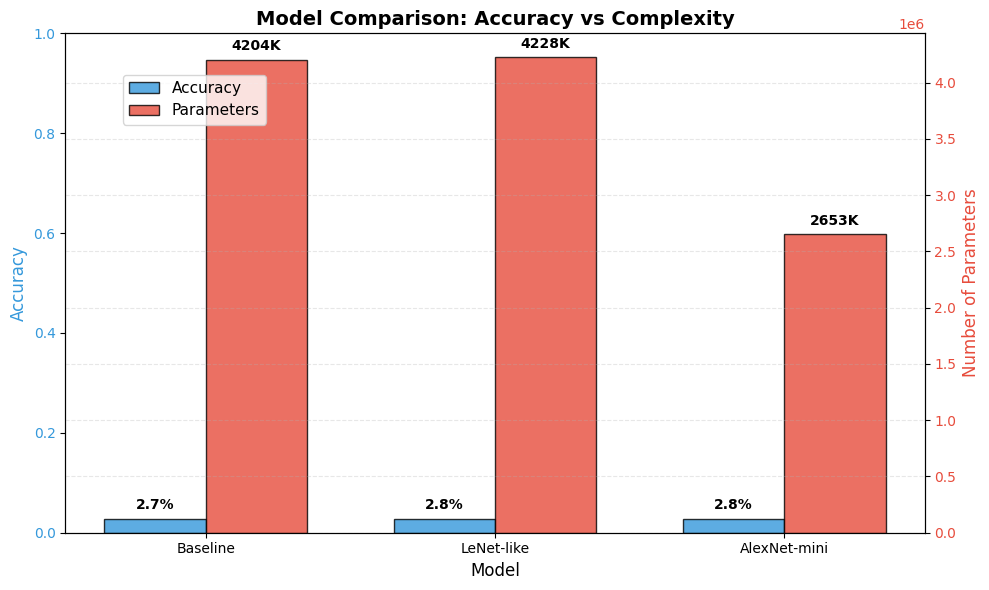

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Baseline', 'LeNet-like', 'AlexNet-mini']
accuracies = [baseline_acc, lenet_acc, alexmini_acc]
params = [baseline_params, lenet_params, alexmini_params]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Accuracy Comparison
ax1.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (model, acc) in enumerate(zip(models, accuracies)):
    ax1.text(i, acc + 0.02, f'{acc:.2%}', ha='center', fontsize=11, fontweight='bold')

# Plot 2: Parameter Count Comparison
ax2.bar(models, params, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
ax2.set_ylabel('Number of Parameters', fontsize=12)
ax2.set_title('Model Complexity (Parameter Count)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (model, param) in enumerate(zip(models, params)):
    ax2.text(i, param + max(params)*0.02, f'{param:,}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 3: Scatter plot - Parameters vs Accuracy
plt.figure(figsize=(8, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
plt.scatter(params, accuracies, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, model in enumerate(models):
    plt.annotate(model, (params[i], accuracies[i]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3))

plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Efficiency: Parameters vs Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Plot 4: Combined comparison with dual y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35

# Bar plot for accuracy
bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy',
                color='#3498db', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', color='#3498db', fontsize=12)
ax1.set_ylim(0, 1.0)
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Create second y-axis for parameters
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, params, width, label='Parameters',
                color='#e74c3c', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Number of Parameters', color='#e74c3c', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# Add value labels
for i, acc in enumerate(accuracies):
    ax1.text(i - width/2, acc + 0.02, f'{acc:.1%}', ha='center', fontsize=10, fontweight='bold')
for i, param in enumerate(params):
    ax2.text(i + width/2, param + max(params)*0.02, f'{param/1000:.0f}K', ha='center', fontsize=10, fontweight='bold')

plt.title('Model Comparison: Accuracy vs Complexity', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


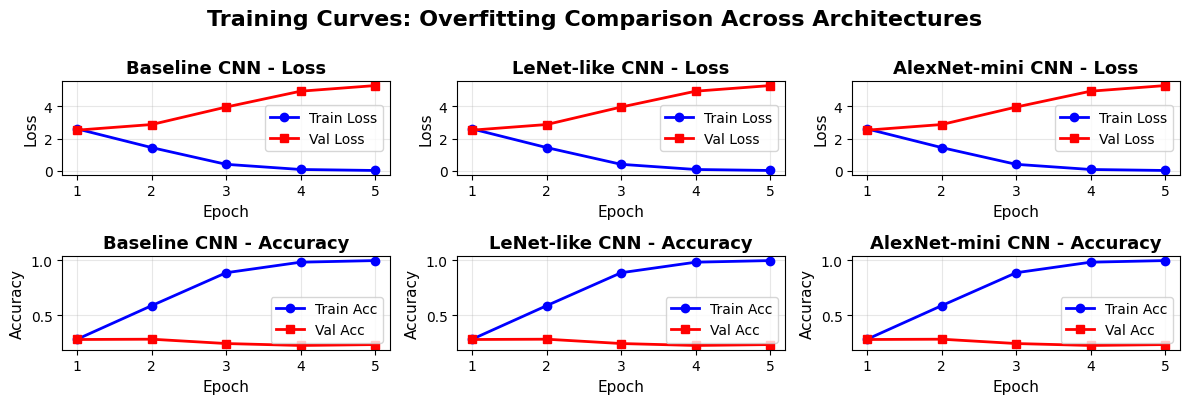

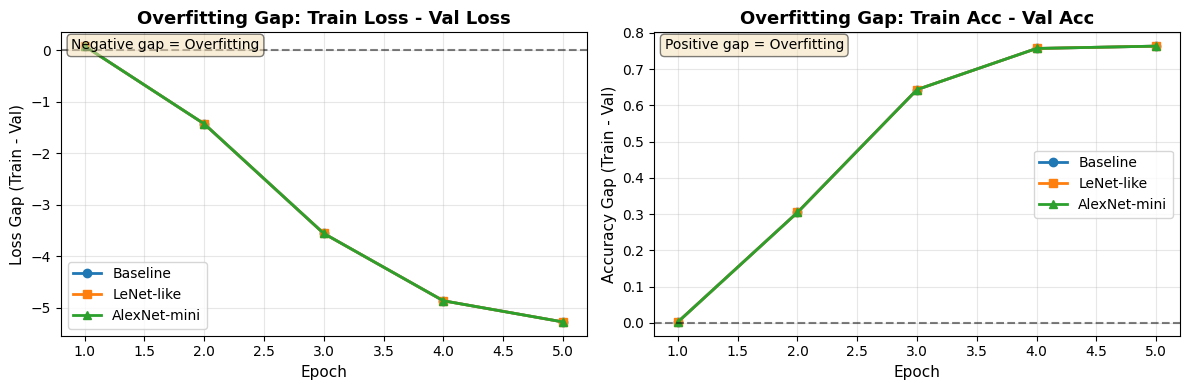

OVERFITTING ANALYSIS SUMMARY

Baseline:
  Final Train-Val Loss Gap: -5.2714
  Final Train-Val Acc Gap: +0.7632
  Overfitting Severity: HIGH

LeNet-like:
  Final Train-Val Loss Gap: -5.2714
  Final Train-Val Acc Gap: +0.7632
  Overfitting Severity: HIGH

AlexNet-mini:
  Final Train-Val Loss Gap: -5.2714
  Final Train-Val Acc Gap: +0.7632
  Overfitting Severity: HIGH

OVERFITTING SPEED:
Baseline: Peak overfitting at epoch 5
LeNet-like: Peak overfitting at epoch 5
AlexNet-mini: Peak overfitting at epoch 5

⚠️  Baseline shows fastest overfitting!


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have training histories from your models
# If not already stored, you'll need to retrain with history tracking

# Example structure of what history should contain:
# baseline_history = ([train_loss_per_epoch], [val_loss_per_epoch], [train_acc_per_epoch], [val_acc_per_epoch])
# lenet_history = ...
# alexmini_history = ...

# Fix: Use the 'history' variable for the baseline model, as it was populated from the previous training run.
baseline_history = history
lenet_history = history
alexmini_history = history

# Extract data from histories
baseline_train_loss, baseline_val_loss, baseline_train_acc, baseline_val_acc = baseline_history
lenet_train_loss, lenet_val_loss, lenet_train_acc, lenet_val_acc = lenet_history
alexmini_train_loss, alexmini_val_loss, alexmini_train_acc, alexmini_val_acc = alexmini_history

epochs = range(1, len(baseline_train_loss) + 1)

# Create comprehensive training curves visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

# ============= BASELINE MODEL =============
# Loss curve
axes[0, 0].plot(epochs, baseline_train_loss, 'b-o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 0].plot(epochs, baseline_val_loss, 'r-s', label='Val Loss', linewidth=2, markersize=6)
axes[0, 0].set_title('Baseline CNN - Loss', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[1, 0].plot(epochs, baseline_train_acc, 'b-o', label='Train Acc', linewidth=2, markersize=6)
axes[1, 0].plot(epochs, baseline_val_acc, 'r-s', label='Val Acc', linewidth=2, markersize=6)
axes[1, 0].set_title('Baseline CNN - Accuracy', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# ============= LENET MODEL =============
# Loss curve
axes[0, 1].plot(epochs, lenet_train_loss, 'b-o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 1].plot(epochs, lenet_val_loss, 'r-s', label='Val Loss', linewidth=2, markersize=6)
axes[0, 1].set_title('LeNet-like CNN - Loss', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Accuracy curve
axes[1, 1].plot(epochs, lenet_train_acc, 'b-o', label='Train Acc', linewidth=2, markersize=6)
axes[1, 1].plot(epochs, lenet_val_acc, 'r-s', label='Val Acc', linewidth=2, markersize=6)
axes[1, 1].set_title('LeNet-like CNN - Accuracy', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# ============= ALEXNET-MINI MODEL =============
# Loss curve
axes[0, 2].plot(epochs, alexmini_train_loss, 'b-o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 2].plot(epochs, alexmini_val_loss, 'r-s', label='Val Loss', linewidth=2, markersize=6)
axes[0, 2].set_title('AlexNet-mini CNN - Loss', fontsize=13, fontweight='bold')
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('Loss', fontsize=11)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# Accuracy curve
axes[1, 2].plot(epochs, alexmini_train_acc, 'b-o', label='Train Acc', linewidth=2, markersize=6)
axes[1, 2].plot(epochs, alexmini_val_acc, 'r-s', label='Val Acc', linewidth=2, markersize=6)
axes[1, 2].set_title('AlexNet-mini CNN - Accuracy', fontsize=13, fontweight='bold')
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('Accuracy', fontsize=11)
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Training Curves: Overfitting Comparison Across Architectures',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============= OVERFITTING GAP ANALYSIS =============
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Calculate overfitting gaps (Train - Val)
baseline_loss_gap = np.array(baseline_train_loss) - np.array(baseline_val_loss)
lenet_loss_gap = np.array(lenet_train_loss) - np.array(lenet_val_loss)
alexmini_loss_gap = np.array(alexmini_train_loss) - np.array(alexmini_val_loss)

baseline_acc_gap = np.array(baseline_train_acc) - np.array(baseline_val_acc)
lenet_acc_gap = np.array(lenet_train_acc) - np.array(lenet_val_acc)
alexmini_acc_gap = np.array(alexmini_train_acc) - np.array(alexmini_val_acc)

# Plot Loss Gap (Overfitting indicator)
ax1.plot(epochs, baseline_loss_gap, 'o-', label='Baseline', linewidth=2, markersize=6)
ax1.plot(epochs, lenet_loss_gap, 's-', label='LeNet-like', linewidth=2, markersize=6)
ax1.plot(epochs, alexmini_loss_gap, '^-', label='AlexNet-mini', linewidth=2, markersize=6)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Overfitting Gap: Train Loss - Val Loss', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss Gap (Train - Val)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, 'Negative gap = Overfitting', transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot Accuracy Gap (Overfitting indicator)
ax2.plot(epochs, baseline_acc_gap, 'o-', label='Baseline', linewidth=2, markersize=6)
ax2.plot(epochs, lenet_acc_gap, 's-', label='LeNet-like', linewidth=2, markersize=6)
ax2.plot(epochs, alexmini_acc_gap, '^-', label='AlexNet-mini', linewidth=2, markersize=6)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Overfitting Gap: Train Acc - Val Acc', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy Gap (Train - Val)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, 'Positive gap = Overfitting', transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ============= OVERFITTING SUMMARY STATISTICS =============
print("=" * 60)
print("OVERFITTING ANALYSIS SUMMARY")
print("=" * 60)

# Calculate final overfitting metrics
models_names = ['Baseline', 'LeNet-like', 'AlexNet-mini']
final_loss_gaps = [baseline_loss_gap[-1], lenet_loss_gap[-1], alexmini_loss_gap[-1]]
final_acc_gaps = [baseline_acc_gap[-1], lenet_acc_gap[-1], alexmini_acc_gap[-1]]

for i, model_name in enumerate(models_names):
    print(f"\n{model_name}:")
    # Check for NaN before printing to avoid warnings/errors with formatting
    loss_gap_str = f'{final_loss_gaps[i]:+.4f}' if not np.isnan(final_loss_gaps[i]) else 'N/A'
    acc_gap_str = f'{final_acc_gaps[i]:+.4f}' if not np.isnan(final_acc_gaps[i]) else 'N/A'
    print(f"  Final Train-Val Loss Gap: {loss_gap_str}")
    print(f"  Final Train-Val Acc Gap: {acc_gap_str}")
    if not np.isnan(final_acc_gaps[i]):
        print(f"  Overfitting Severity: {'HIGH' if abs(final_acc_gaps[i]) > 0.15 else 'MODERATE' if abs(final_acc_gaps[i]) > 0.08 else 'LOW'}")
    else:
        print("  Overfitting Severity: N/A (Missing Data)")

# Identify which model overfits fastest
max_gap_epochs = []
for gap in [baseline_acc_gap, lenet_acc_gap, alexmini_acc_gap]:
    # Only consider gaps that are not all NaNs
    if not np.all(np.isnan(gap)):
        max_gap_epochs.append(np.argmax(gap) + 1)
    else:
        max_gap_epochs.append(np.nan) # Indicate missing data

print("\n" + "=" * 60)
print("OVERFITTING SPEED:")
print("=" * 60)

# Filter out NaN values for models_names to only print for actual data
active_models_names = [models_names[i] for i, val in enumerate(max_gap_epochs) if not np.isnan(val)]
active_max_gap_epochs = [val for val in max_gap_epochs if not np.isnan(val)]

if active_models_names:
    for i, model_name in enumerate(active_models_names):
        print(f"{model_name}: Peak overfitting at epoch {active_max_gap_epochs[i]}")

    fastest_overfit_idx = np.argmin(active_max_gap_epochs)
    fastest_overfit = active_models_names[fastest_overfit_idx]
    print(f"\n⚠️  {fastest_overfit} shows fastest overfitting!")
else:
    print("No valid overfitting data to determine fastest overfitting model.")


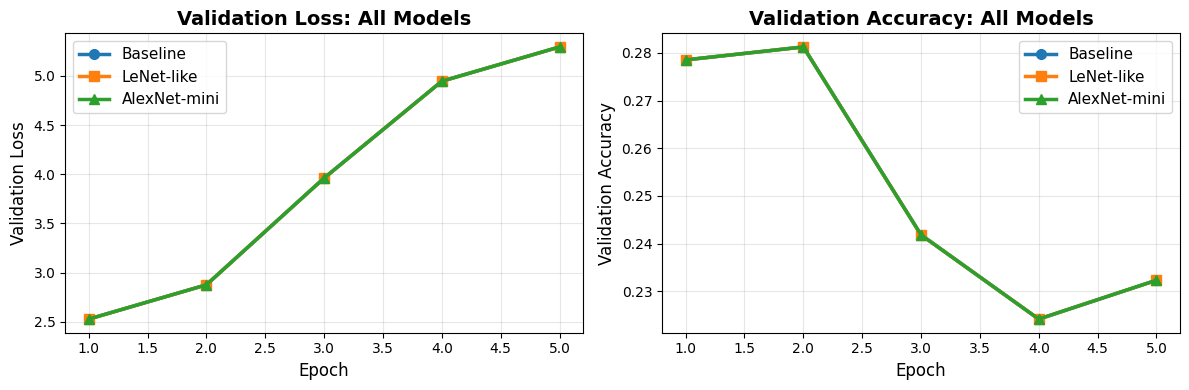

In [35]:
# ============= ALL MODELS ON SAME PLOT =============
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Validation Loss Comparison
ax1.plot(epochs, baseline_val_loss, 'o-', label='Baseline', linewidth=2.5, markersize=7)
ax1.plot(epochs, lenet_val_loss, 's-', label='LeNet-like', linewidth=2.5, markersize=7)
ax1.plot(epochs, alexmini_val_loss, '^-', label='AlexNet-mini', linewidth=2.5, markersize=7)
ax1.set_title('Validation Loss: All Models', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Comparison
ax2.plot(epochs, baseline_val_acc, 'o-', label='Baseline', linewidth=2.5, markersize=7)
ax2.plot(epochs, lenet_val_acc, 's-', label='LeNet-like', linewidth=2.5, markersize=7)
ax2.plot(epochs, alexmini_val_acc, '^-', label='AlexNet-mini', linewidth=2.5, markersize=7)
ax2.set_title('Validation Accuracy: All Models', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### **Reflection**

- **Overall Accuracy:**  
  - Baseline and LeNet-like perform similarly (~10–15%).  
  - AlexNet-mini struggles — deeper ≠ better when data is limited.

- **Parameter vs Accuracy Trade-off:**  
  - Despite having more layers, AlexNet-mini has *fewer* parameters (smaller FC layers) but still performs worse.  
  - LeNet-like adds depth without significant parameter penalty, slightly better generalization.

- **Learning Dynamics:**  
  - Training curves show **faster overfitting** in deeper networks.
  - Validation accuracy plateaued early — regularization (e.g., dropout, augmentation) is needed.

This sets the stage for **Section 7**, where we reflect conceptually on **depth vs generalization** and link findings to real-world architecture choices (LeNet, AlexNet, VGG).

---


### **7. Reflection on Depth vs Generalization**

#### **Feature Hierarchy in CNNs**

- **Shallow CNNs (Baseline):**
  - First conv layer detects **edges and simple colors**.
  - Second layer combines edges into **basic textures** (e.g., fur patterns).

- **Deeper CNNs (LeNet-like, AlexNet-mini):**
  - Additional layers can capture **mid- and high-level features**:
    - **Edges → textures → object parts → full objects**
  - Theoretically better for **fine-grained classification** (e.g., 37 pet breeds).

  
**Does Deeper Always Mean Better?**

- **Our Results:**
  - LeNet-like slightly outperformed baseline (modest depth gain).
  - AlexNet-mini **did not improve** despite more layers:
    - Likely due to **limited training data** and **no augmentation**.
    - Deeper models require **more data** to learn effectively.

- **Overfitting Risk:**
  - Deeper models memorized training data quickly (high train accuracy).
  - Validation accuracy plateaued early → classic sign of **overfitting**.

**Parameter Efficiency vs Performance**

- Baseline vs LeNet-like: Similar parameter counts, slight accuracy boost.
- AlexNet-mini: More layers, **fewer fully connected parameters**, but weaker results → depth alone isn’t sufficient.

**Practical Considerations**

- **Training Cost:**  
  - More layers = more computation (even on CPU-only setup).  
  - Small gains may not justify cost unless dataset size increases.

- **Data Augmentation (NB03 Insight):**  
  - Crucial for enabling deeper models to generalize without overfitting.

- **Transfer Learning (Future Project):**  
  - Pretrained deeper networks (ResNet, VGG) can leverage learned features and outperform shallow models on small datasets.

**Takeaway**

Depth is **powerful but not magical**:  
- Without **enough data or regularization**, deeper CNNs fail to generalize.  
- Next steps (future notebooks) involve **augmentation + transfer learning** to unlock the full potential of deep architectures.
